This notebook covers:

1. Loading tabular data with pandas
2. Data validation and quality checks
3. Basic data exploration and statistics
4. Data visualization and relationships

The data format follows these requirements:
- Each row represents a unique sample with a distinct sample_id
- Features are numeric values used for classification
- Labels represent classification groups (can be repeated across samples)


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import toml
from typing import Dict, Any

# Configure pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

def load_config(config_path: str) -> Dict[str, Any]:
    """
    Load configuration from a TOML file.
    
    Args:
        config_path: Path to the TOML configuration file
        
    Returns:
        Dictionary containing the configuration parameters
    """
    try:
        config = toml.load(config_path)
        print("Configuration loaded successfully!")
        return config
    except Exception as e:
        print(f"Error loading configuration: {str(e)}")
        raise

# Load configuration
config = load_config(Path('../config.toml'))

# Apply visualization settings from config
if 'visualization' in config:
    if 'dpi' in config['visualization']:
        plt.rcParams['figure.dpi'] = config['visualization']['dpi']
    if 'figure_size' in config['visualization']:
        plt.rcParams['figure.figsize'] = config['visualization']['figure_size']
    if 'color_palette' in config['visualization']:
        sns.set_palette(config['visualization']['color_palette'])


Configuration loaded successfully!


## 1. Load Data

The data structure follows these rules:
- Each row represents a unique sample with a distinct `sample_id`
- Features are numeric values for classification
- `labels` can be repeated as they represent classification groups

Let's load and examine this data:


In [2]:

# Load the data using config
data_config = config['data']
data_path = data_config['input_path']
df = pd.read_csv(data_path)

# Get column names from config
sample_id_col = data_config['sample_id_column']
label_col = data_config['label_column']

# Get feature columns
if data_config['feature_columns']:
    # Use explicitly specified feature columns
    feature_cols = data_config['feature_columns']
else:
    # Auto-detect feature columns (all numeric columns except sample_id and label)
    feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if sample_id_col in feature_cols:
        feature_cols.index = df[sample_id_col]
        feature_cols.remove(sample_id_col)
    if label_col in feature_cols:
        feature_cols.remove(label_col)

# Display basic information about the dataset
print("Dataset Info:")
print("-" * 40)
print(f"Number of samples: {len(df)}")
print(f"Number of features: {len(feature_cols)}")
print(f"Feature names: {feature_cols}")
print(f"Number of unique samples: {df[sample_id_col].nunique()}")
print(f"Unique labels: {df[label_col].unique()}")
print(f"Label distribution: {df[label_col].value_counts().to_dict()}")

# Basic data validation
print("\nData Validation:")
print("-" * 40)

# Check for duplicate sample IDs
if len(df) != df[sample_id_col].nunique():
    print("\nWARNING: Duplicate sample IDs found!")
    duplicates = df[df[sample_id_col].duplicated(keep=False)]
    print(duplicates[[sample_id_col, label_col]])

# Check for missing values
missing_values = df.isnull().sum()
if missing_values.any():
    print("\nWARNING: Missing values found:")
    print(missing_values[missing_values > 0])


Dataset Info:
----------------------------------------
Number of samples: 172
Number of features: 4360
Feature names: ['hsa-let-7a-1', 'hsa-let-7a-2', 'hsa-let-7a-3', 'hsa-let-7b', 'hsa-let-7c', 'hsa-let-7d', 'hsa-let-7e', 'hsa-let-7f-1', 'hsa-let-7f-2', 'hsa-let-7g', 'hsa-let-7i', 'hsa-mir-1-1', 'hsa-mir-1-2', 'hsa-mir-100', 'hsa-mir-101-1', 'hsa-mir-101-2', 'hsa-mir-10226', 'hsa-mir-10392', 'hsa-mir-10393', 'hsa-mir-10394', 'hsa-mir-10395', 'hsa-mir-10396a', 'hsa-mir-10396b', 'hsa-mir-10397', 'hsa-mir-10398', 'hsa-mir-10399', 'hsa-mir-103a-1', 'hsa-mir-103a-2', 'hsa-mir-103b-1', 'hsa-mir-103b-2', 'hsa-mir-10400', 'hsa-mir-10401', 'hsa-mir-105-1', 'hsa-mir-105-2', 'hsa-mir-10522', 'hsa-mir-10523', 'hsa-mir-10524', 'hsa-mir-10525', 'hsa-mir-10526', 'hsa-mir-10527', 'hsa-mir-106a', 'hsa-mir-106b', 'hsa-mir-107', 'hsa-mir-10a', 'hsa-mir-10b', 'hsa-mir-11181', 'hsa-mir-11399', 'hsa-mir-11400', 'hsa-mir-11401', 'hsa-mir-1178', 'hsa-mir-1179', 'hsa-mir-1180', 'hsa-mir-1181', 'hsa-mir-1182',

Log transformation

In [3]:
if config['preprocessing']['log_transform'] == "log2":
    df[feature_cols] = np.log2(df[feature_cols]+1)
    print("Log2 transformation applied")
elif config['preprocessing']['log_transform'] == "log10":
    df[feature_cols] = np.log10(df[feature_cols]+1)
    print("Log10 transformation applied")
elif config['preprocessing']['log_transform'] == "ln":
    df[feature_cols] = np.log(df[feature_cols]+1)
    print("Natural logarithm transformation applied")
else:
    print("No log transformation applied")

Log10 transformation applied


## 2. Data Validation

Let's perform some basic validation checks on the input data:
1. Check for missing values
2. Verify data types (numeric features, categorical labels)
3. Check value ranges and distributions
4. Validate label categories


In [4]:
# 1. Check for missing values
print("Missing Values Check:")
print("-" * 40)
print(df.isnull().sum())

# 2. Verify data types
print("\nData Types Check:")
print("-" * 40)
print(df.dtypes)

# 3. Validate sample_ids
print("\nSample ID Validation:")
print("-" * 40)
print(f"Number of sample_ids: {len(df['sample_id'])}")
print(f"Number of unique sample_ids: {df['sample_id'].nunique()}")
if len(df['sample_id']) != df['sample_id'].nunique():
    print("WARNING: Duplicate sample_ids found!")
    print("\nDuplicate sample_ids:")
    print(df['sample_id'].value_counts()[df['sample_id'].value_counts() > 1])

# 4. Check value ranges for numeric features
print("\nValue Ranges for Features:")
print("-" * 40)
for col in df.columns[:5]:  # Exclude sample_id and label columns
    if col not in [sample_id_col, label_col]:
        print(f"{col}:")
        print(f"  Min: {df[col].min():.3f}")
        print(f"  Max: {df[col].max():.3f}")
        print(f"  Mean: {df[col].mean():.3f}")
        print(f"  Std: {df[col].std():.3f}")

# 5. Validate labels
print("\nLabel Distribution:")
print("-" * 40)
print("Label counts:")
print(df['label'].value_counts())
print("\nSamples per label:")
for label in df['label'].unique():
    print(f"\nLabel {label}:")
    print(df[df['label'] == label]['sample_id'].tolist())


Missing Values Check:
----------------------------------------
sample_id         0
hsa-let-7a-1      0
hsa-let-7a-2      0
hsa-let-7a-3      0
hsa-let-7b        0
                 ..
hsa-miR-99a-3p    0
hsa-miR-99a-5p    0
hsa-miR-99b-3p    0
hsa-miR-99b-5p    0
label             0
Length: 4362, dtype: int64

Data Types Check:
----------------------------------------
sample_id          object
hsa-let-7a-1      float64
hsa-let-7a-2      float64
hsa-let-7a-3      float64
hsa-let-7b        float64
                   ...   
hsa-miR-99a-3p    float64
hsa-miR-99a-5p    float64
hsa-miR-99b-3p    float64
hsa-miR-99b-5p    float64
label              object
Length: 4362, dtype: object

Sample ID Validation:
----------------------------------------
Number of sample_ids: 172
Number of unique sample_ids: 172

Value Ranges for Features:
----------------------------------------
hsa-let-7a-1:
  Min: 1.079
  Max: 4.486
  Mean: 2.964
  Std: 0.639
hsa-let-7a-2:
  Min: 0.954
  Max: 4.476
  Mean: 2.944
  S

['220308_HER2_E46a', '220308_LumA_E10a', '220308_LumA_E19a', '220308_LumB_E20a', '220308_TNBC_E31a', '220308_TNBC_E71a', '220629_HER2_E14a', '220629_HER2_E15a', '220629_HER2_E39a', '220629_HER2_E49a', '220629_HER2_E52a', '220629_LumA_E13a', '220629_LumA_E16a', '220629_LumA_E18a', '220629_LumA_E6a', '220629_LumA_E7a', '220629_LumA_E8a', '220629_LumA_E9a', '220629_LumB_E1a', '220629_LumB_E21a', '220629_LumB_E23a', '220629_LumB_E36a', '220629_LumB_E3a', '220629_LumB_E4a', '220629_LumB_E51a', '220629_TNBC_E17a', '220629_TNBC_E22a', '220629_TNBC_E27a', '220629_TNBC_E2a', '220629_TNBC_E5a', '220629_TNBC_E77a', '220629_TNBC_E82a', '250213_HER2_E101a', '250213_HER2_E102a', '250213_HER2_E103a', '250213_HER2_E105a', '250213_HER2_E107a', '250213_HER2_E111a', '250213_HER2_E116a', '250213_HER2_E124a', '250213_HER2_E125a', '250213_HER2_E136a', '250213_HER2_E146a', '250213_HER2_E148a', '250213_HER2_E162a', '250213_HER2_E165a', '250213_HER2_E169a', '250213_HER2_E174a', '250213_HER2_E83a', '250213_HER2

['220308_Healthy_E34a', '220308_Healthy_E35a', '220308_Healthy_E37a', '220308_Healthy_E38a', '220308_Healthy_E72a', '220308_Healthy_E73a', '220629_Healthy_E11a', '220629_Healthy_E12a', '220629_Healthy_E24a', '220629_Healthy_E25a', '220629_Healthy_E26a', '220629_Healthy_E28a', '220629_Healthy_E29a', '220629_Healthy_E30a', '220629_Healthy_E32a', '220629_Healthy_E33a', '220629_Healthy_E40a', '220629_Healthy_E41a', '220629_Healthy_E42a', '220629_Healthy_E43a', '220629_Healthy_E44a', '220629_Healthy_E45a', '220629_Healthy_E47a', '220629_Healthy_E48a', '220629_Healthy_E50a', '220629_Healthy_E53a', '220629_Healthy_E54a', '220629_Healthy_E55a', '220629_Healthy_E56a', '220629_Healthy_E57a', '220629_Healthy_E58a', '220629_Healthy_E59a', '220629_Healthy_E60a', '220629_Healthy_E61a', '220629_Healthy_E62a', '220629_Healthy_E63a', '220629_Healthy_E64a', '220629_Healthy_E65a', '220629_Healthy_E66a', '220629_Healthy_E67a', '220629_Healthy_E68a', '220629_Healthy_E69a', '220629_Healthy_E70a', '220629_He

## 3. Data Visualization

### Label distribution

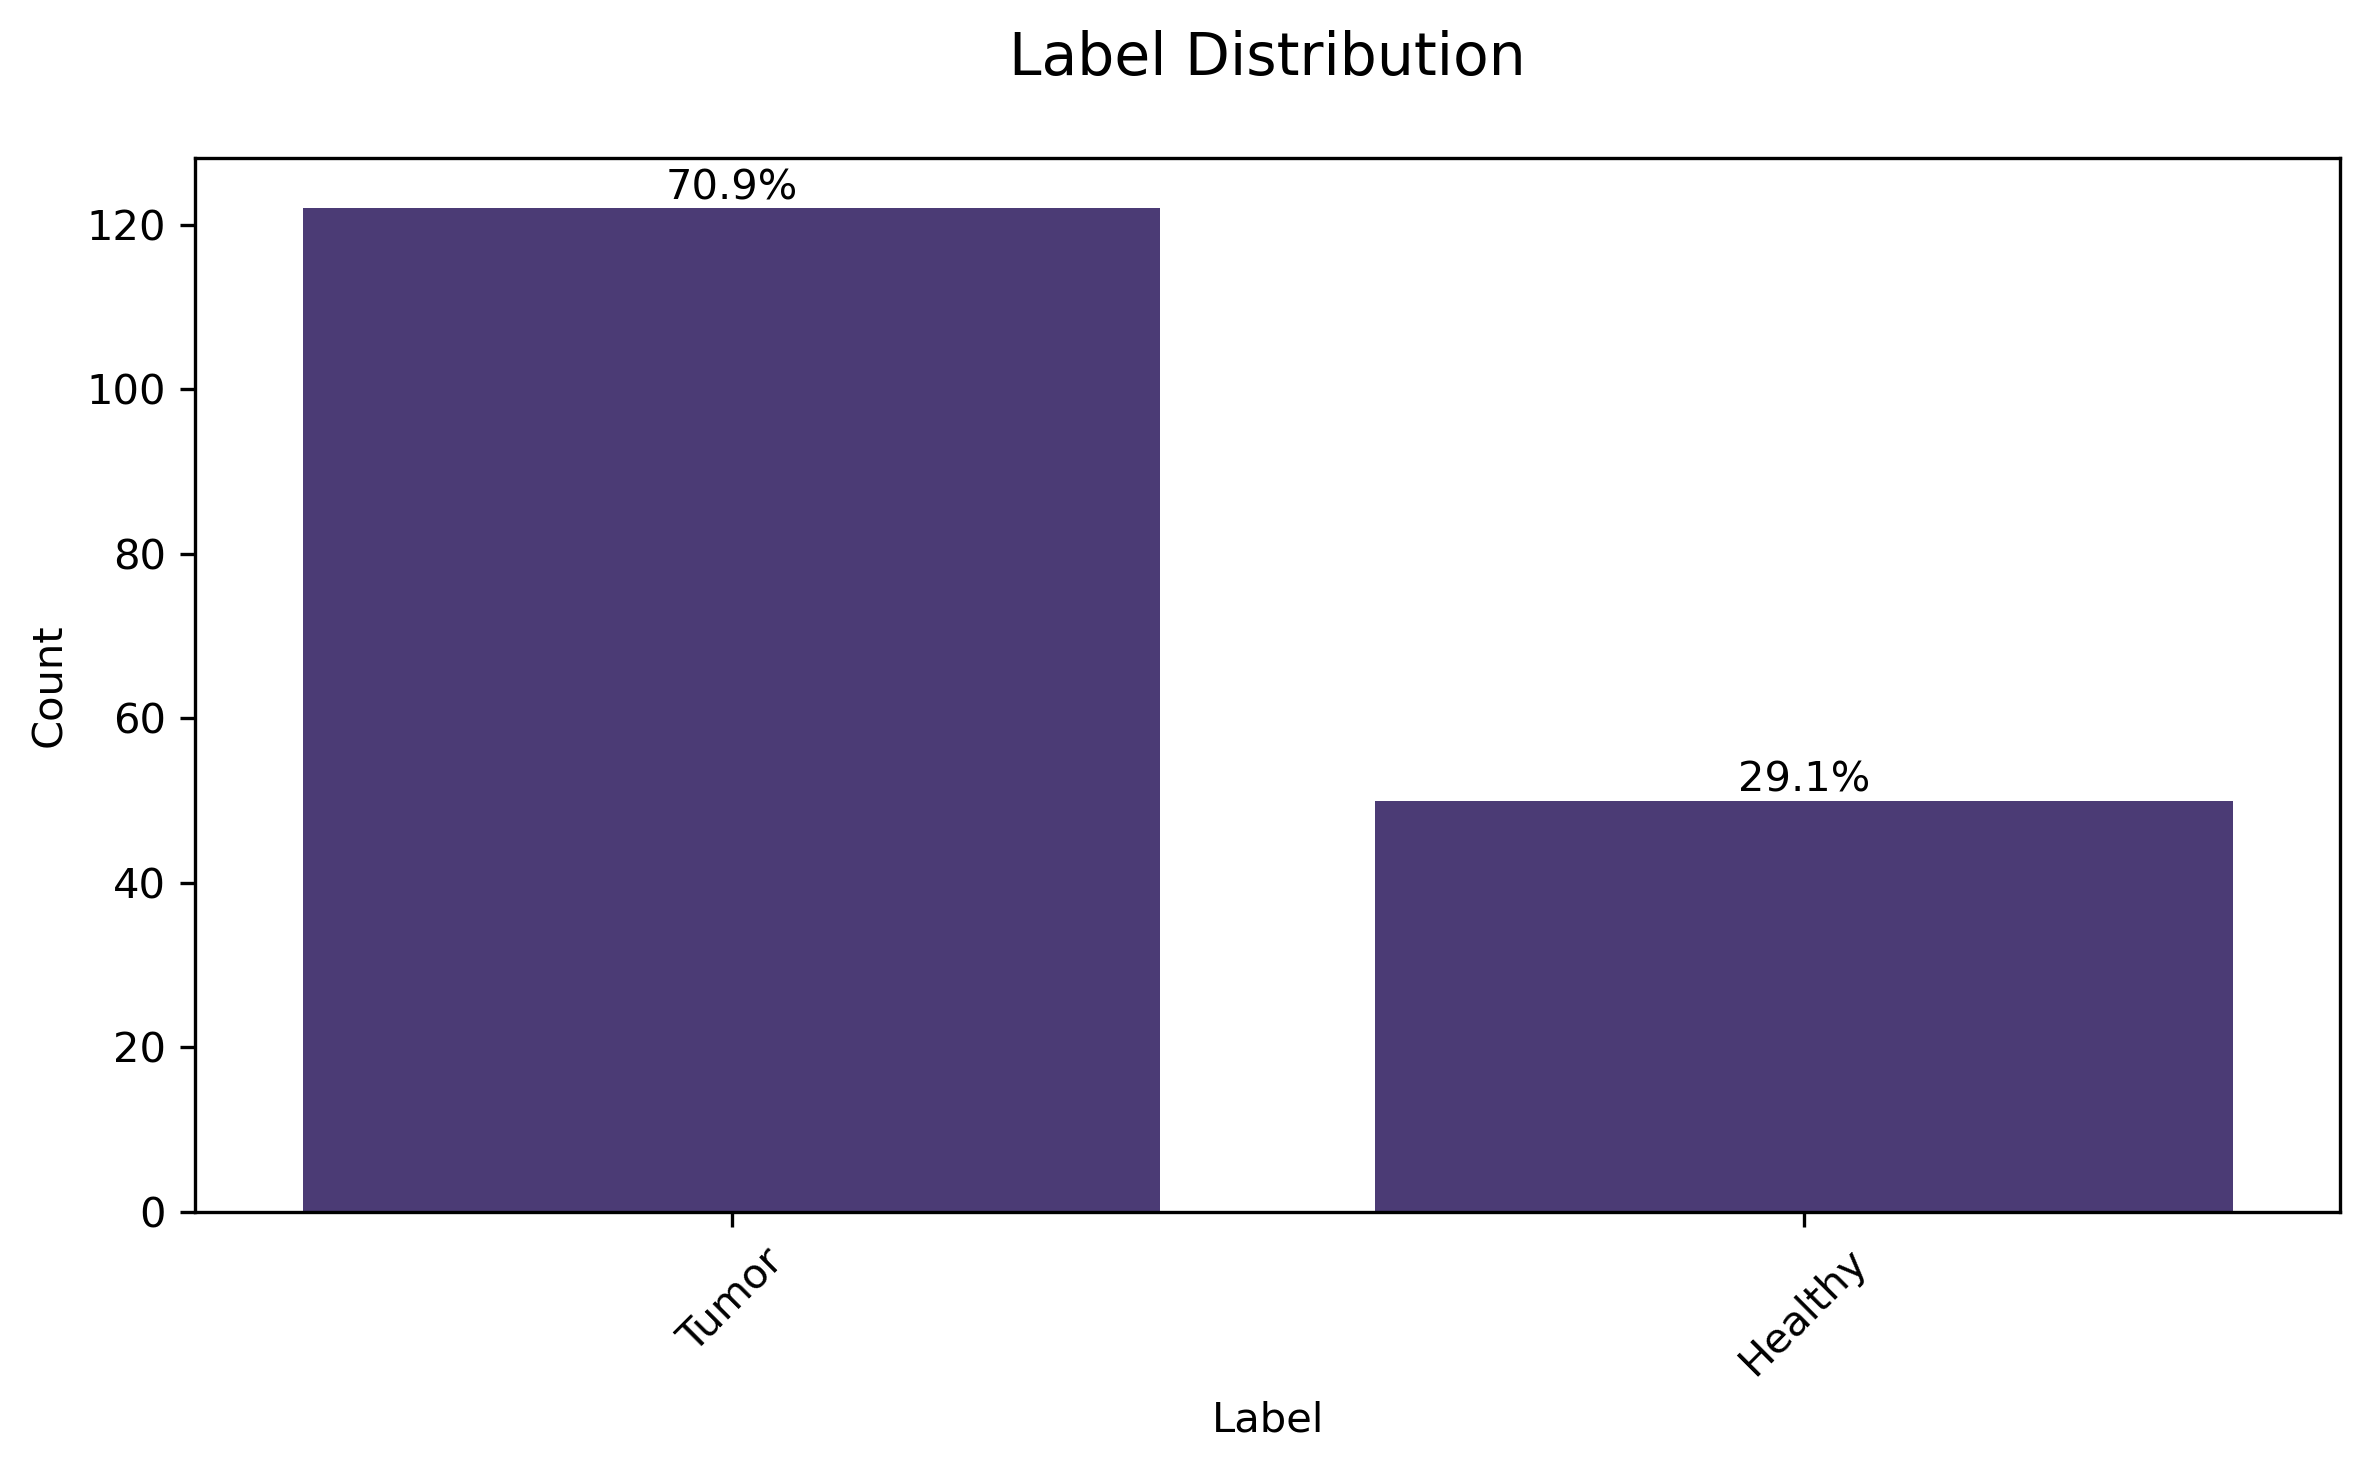

In [5]:
# Set default visualization parameters
default_fig_size = (15, 10)
default_color_palette = 'viridis'

# Get visualization settings from config if available
viz_config = config.get('visualization', {})
fig_size = viz_config.get('figure_size', default_fig_size)
color_palette = viz_config.get('color_palette', default_color_palette)

# Set color palette
sns.set_palette(color_palette)

# Function to select top features by variance
def select_top_features(data, feature_cols, n=100):
    """Select top N features by variance."""
    variances = data[feature_cols].var().sort_values(ascending=False)
    return variances.head(n).index.tolist()

# Function to create feature correlation matrix
def compute_feature_correlations(data, features):
    """Compute correlation matrix for selected features."""
    return data[features].corr()

# 1. Label Distribution Analysis
plt.figure(figsize=fig_size)
plt.title('Label Distribution', pad=20, fontsize=14)
sns.countplot(data=df, x=label_col)
plt.xticks(rotation=45)
plt.xlabel('Label')
plt.ylabel('Count')

# Add percentage labels on top of bars
total = len(df)
for p in plt.gca().patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    plt.annotate(percentage, (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()




Generating Feature Distribution Heatmap...
Selecting top 100 features by variance out of 4360 total features


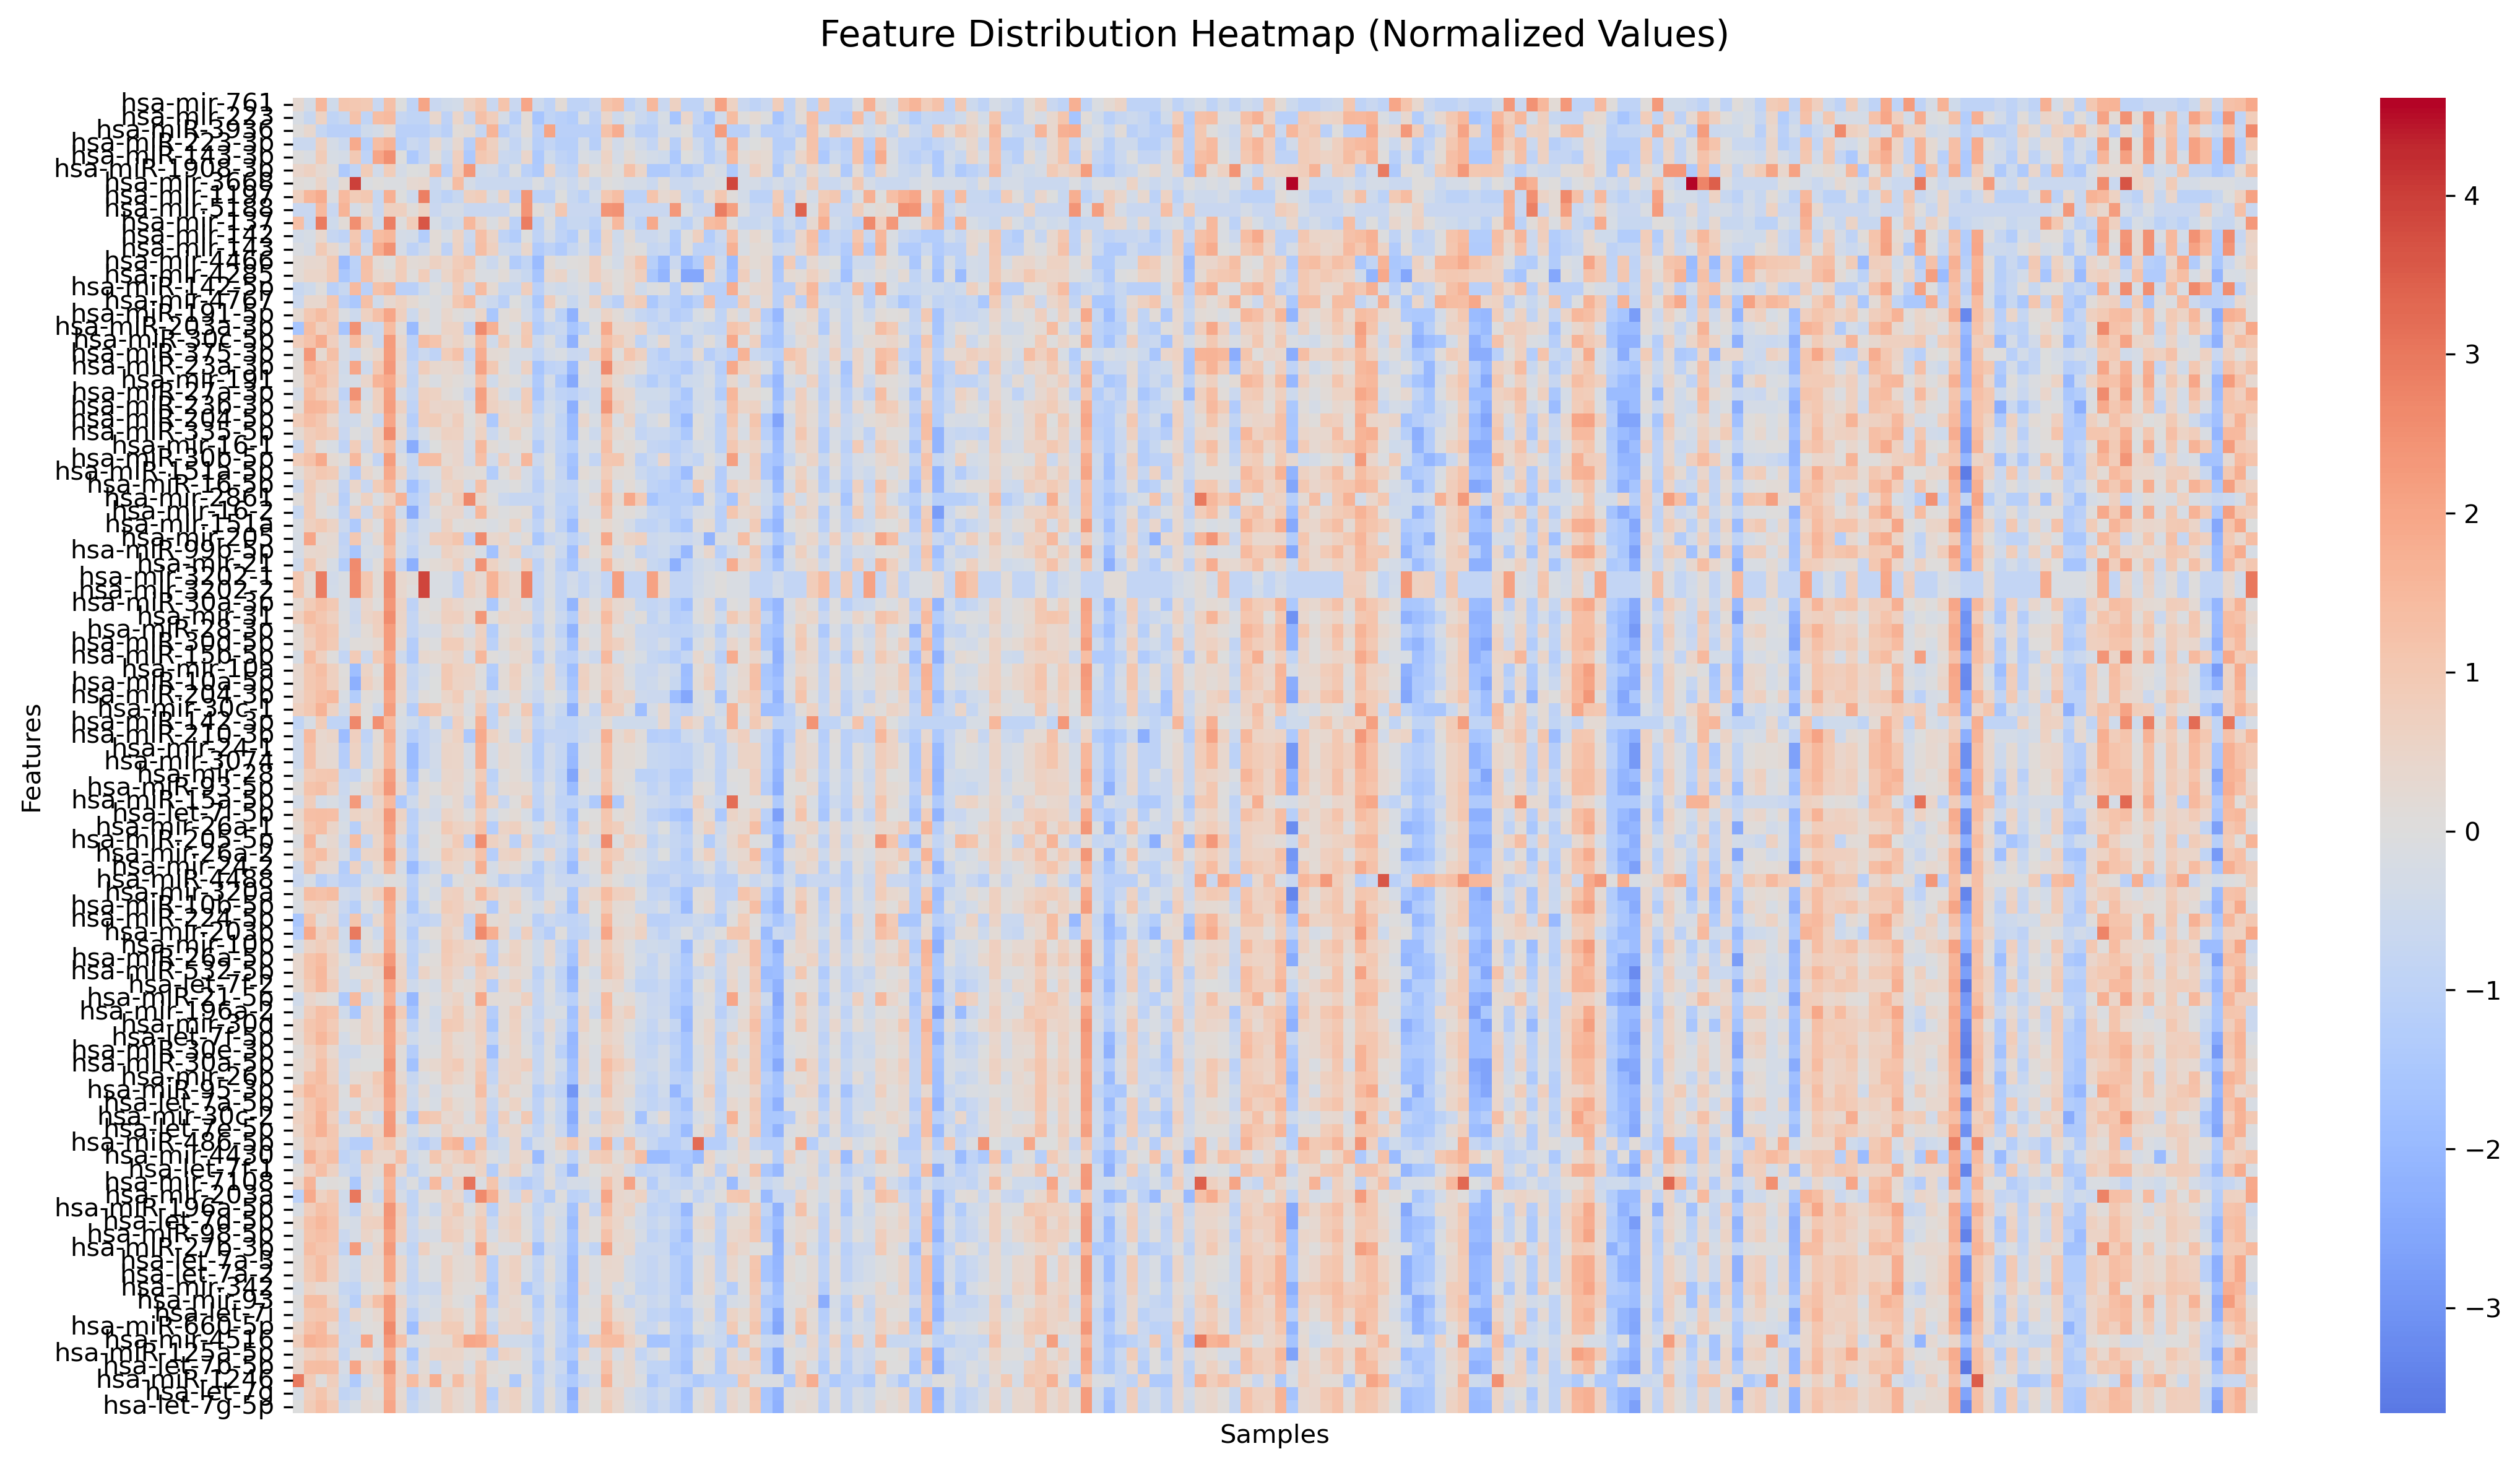

In [6]:
# 2. Feature Distribution Heatmap
print("\nGenerating Feature Distribution Heatmap...")
# Select top features by variance if there are too many
n_features = len(feature_cols)
if n_features > 100:
    print(f"Selecting top 100 features by variance out of {n_features} total features")
    selected_features = select_top_features(df, feature_cols, n=100)
else:
    selected_features = feature_cols

# Create feature distribution heatmap
plt.figure(figsize=(15, 8))
plt.title('Feature Distribution Heatmap (Normalized Values)', pad=20, fontsize=14)

# Normalize and plot feature values
feature_data = df[selected_features].apply(lambda x: (x - x.mean()) / x.std())
sns.heatmap(feature_data.T, cmap='coolwarm', center=0, 
            yticklabels=True, xticklabels=False)
plt.xlabel('Samples')
plt.ylabel('Features')
plt.tight_layout()
plt.show()

### Feature correlations


Generating Feature Correlation Analysis...


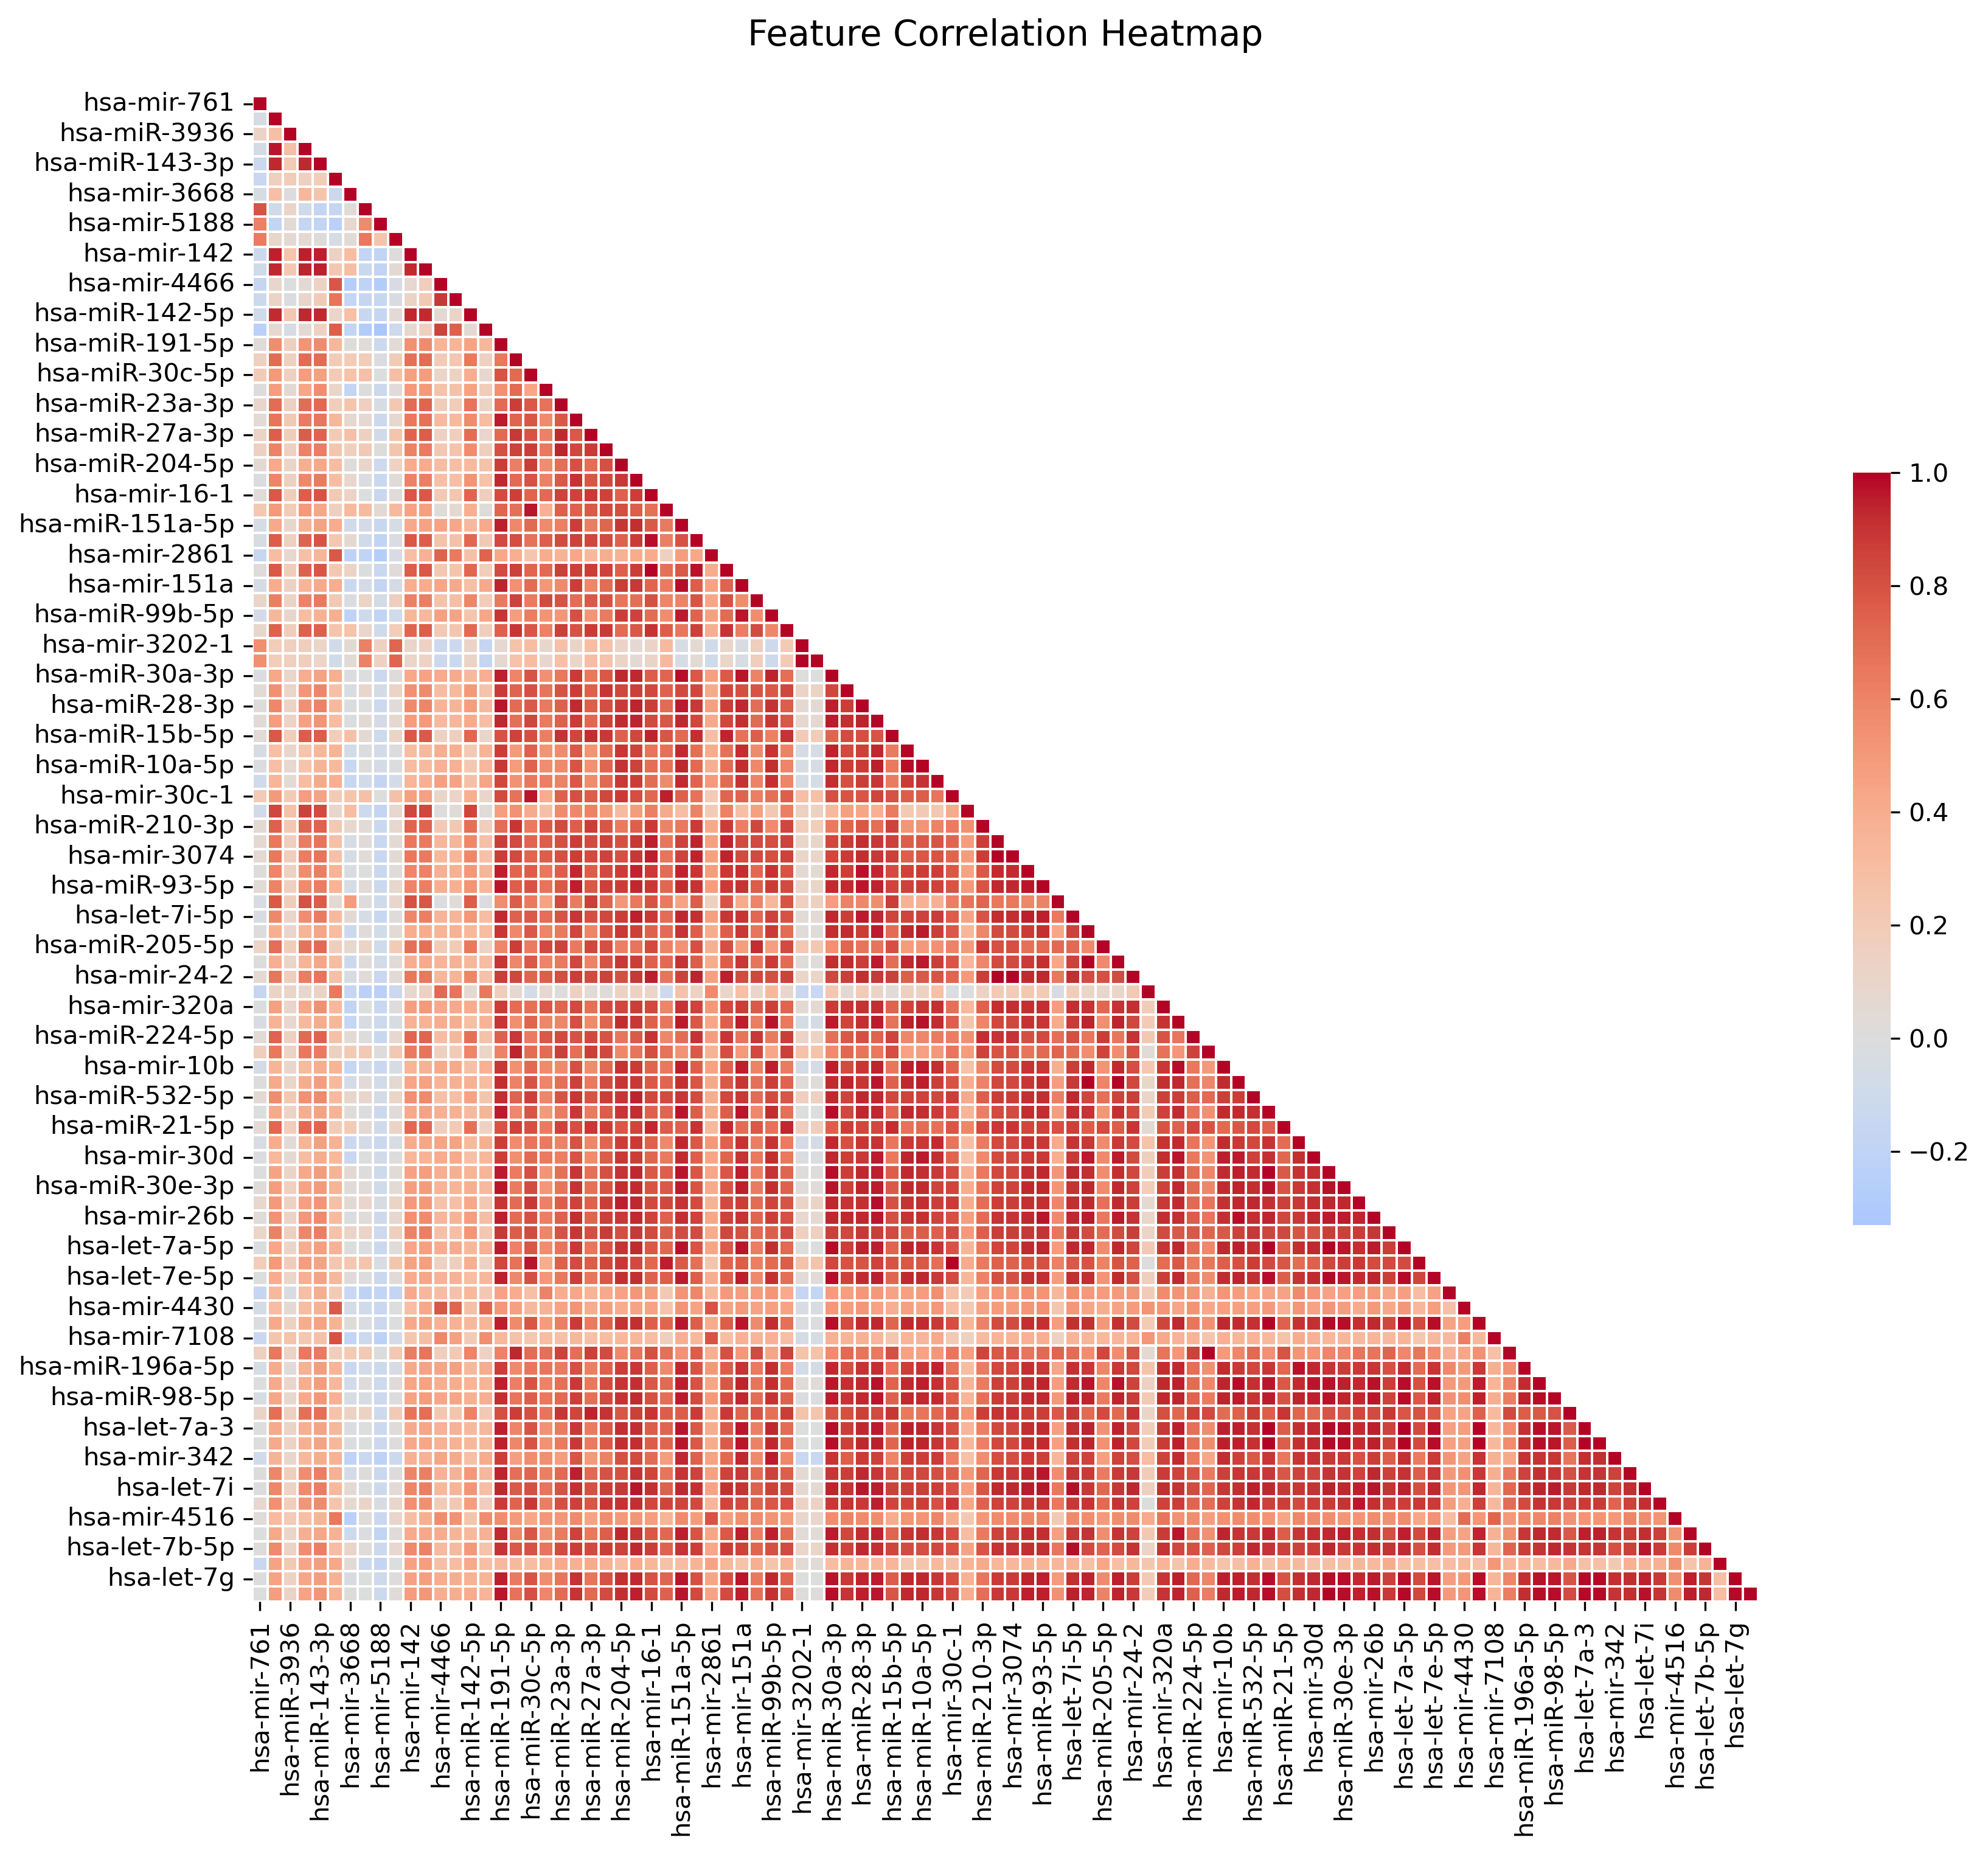

In [7]:
# 3. Feature Correlation Analysis
print("\nGenerating Feature Correlation Analysis...")
# Compute correlations for selected features
correlation_matrix = compute_feature_correlations(df, selected_features)

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
plt.title('Feature Correlation Heatmap', pad=20, fontsize=14)
mask = np.triu(np.ones_like(correlation_matrix), k=1)
sns.heatmap(correlation_matrix, mask=mask, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .5})
plt.tight_layout()
plt.show()

### PCA


Performing PCA Analysis...


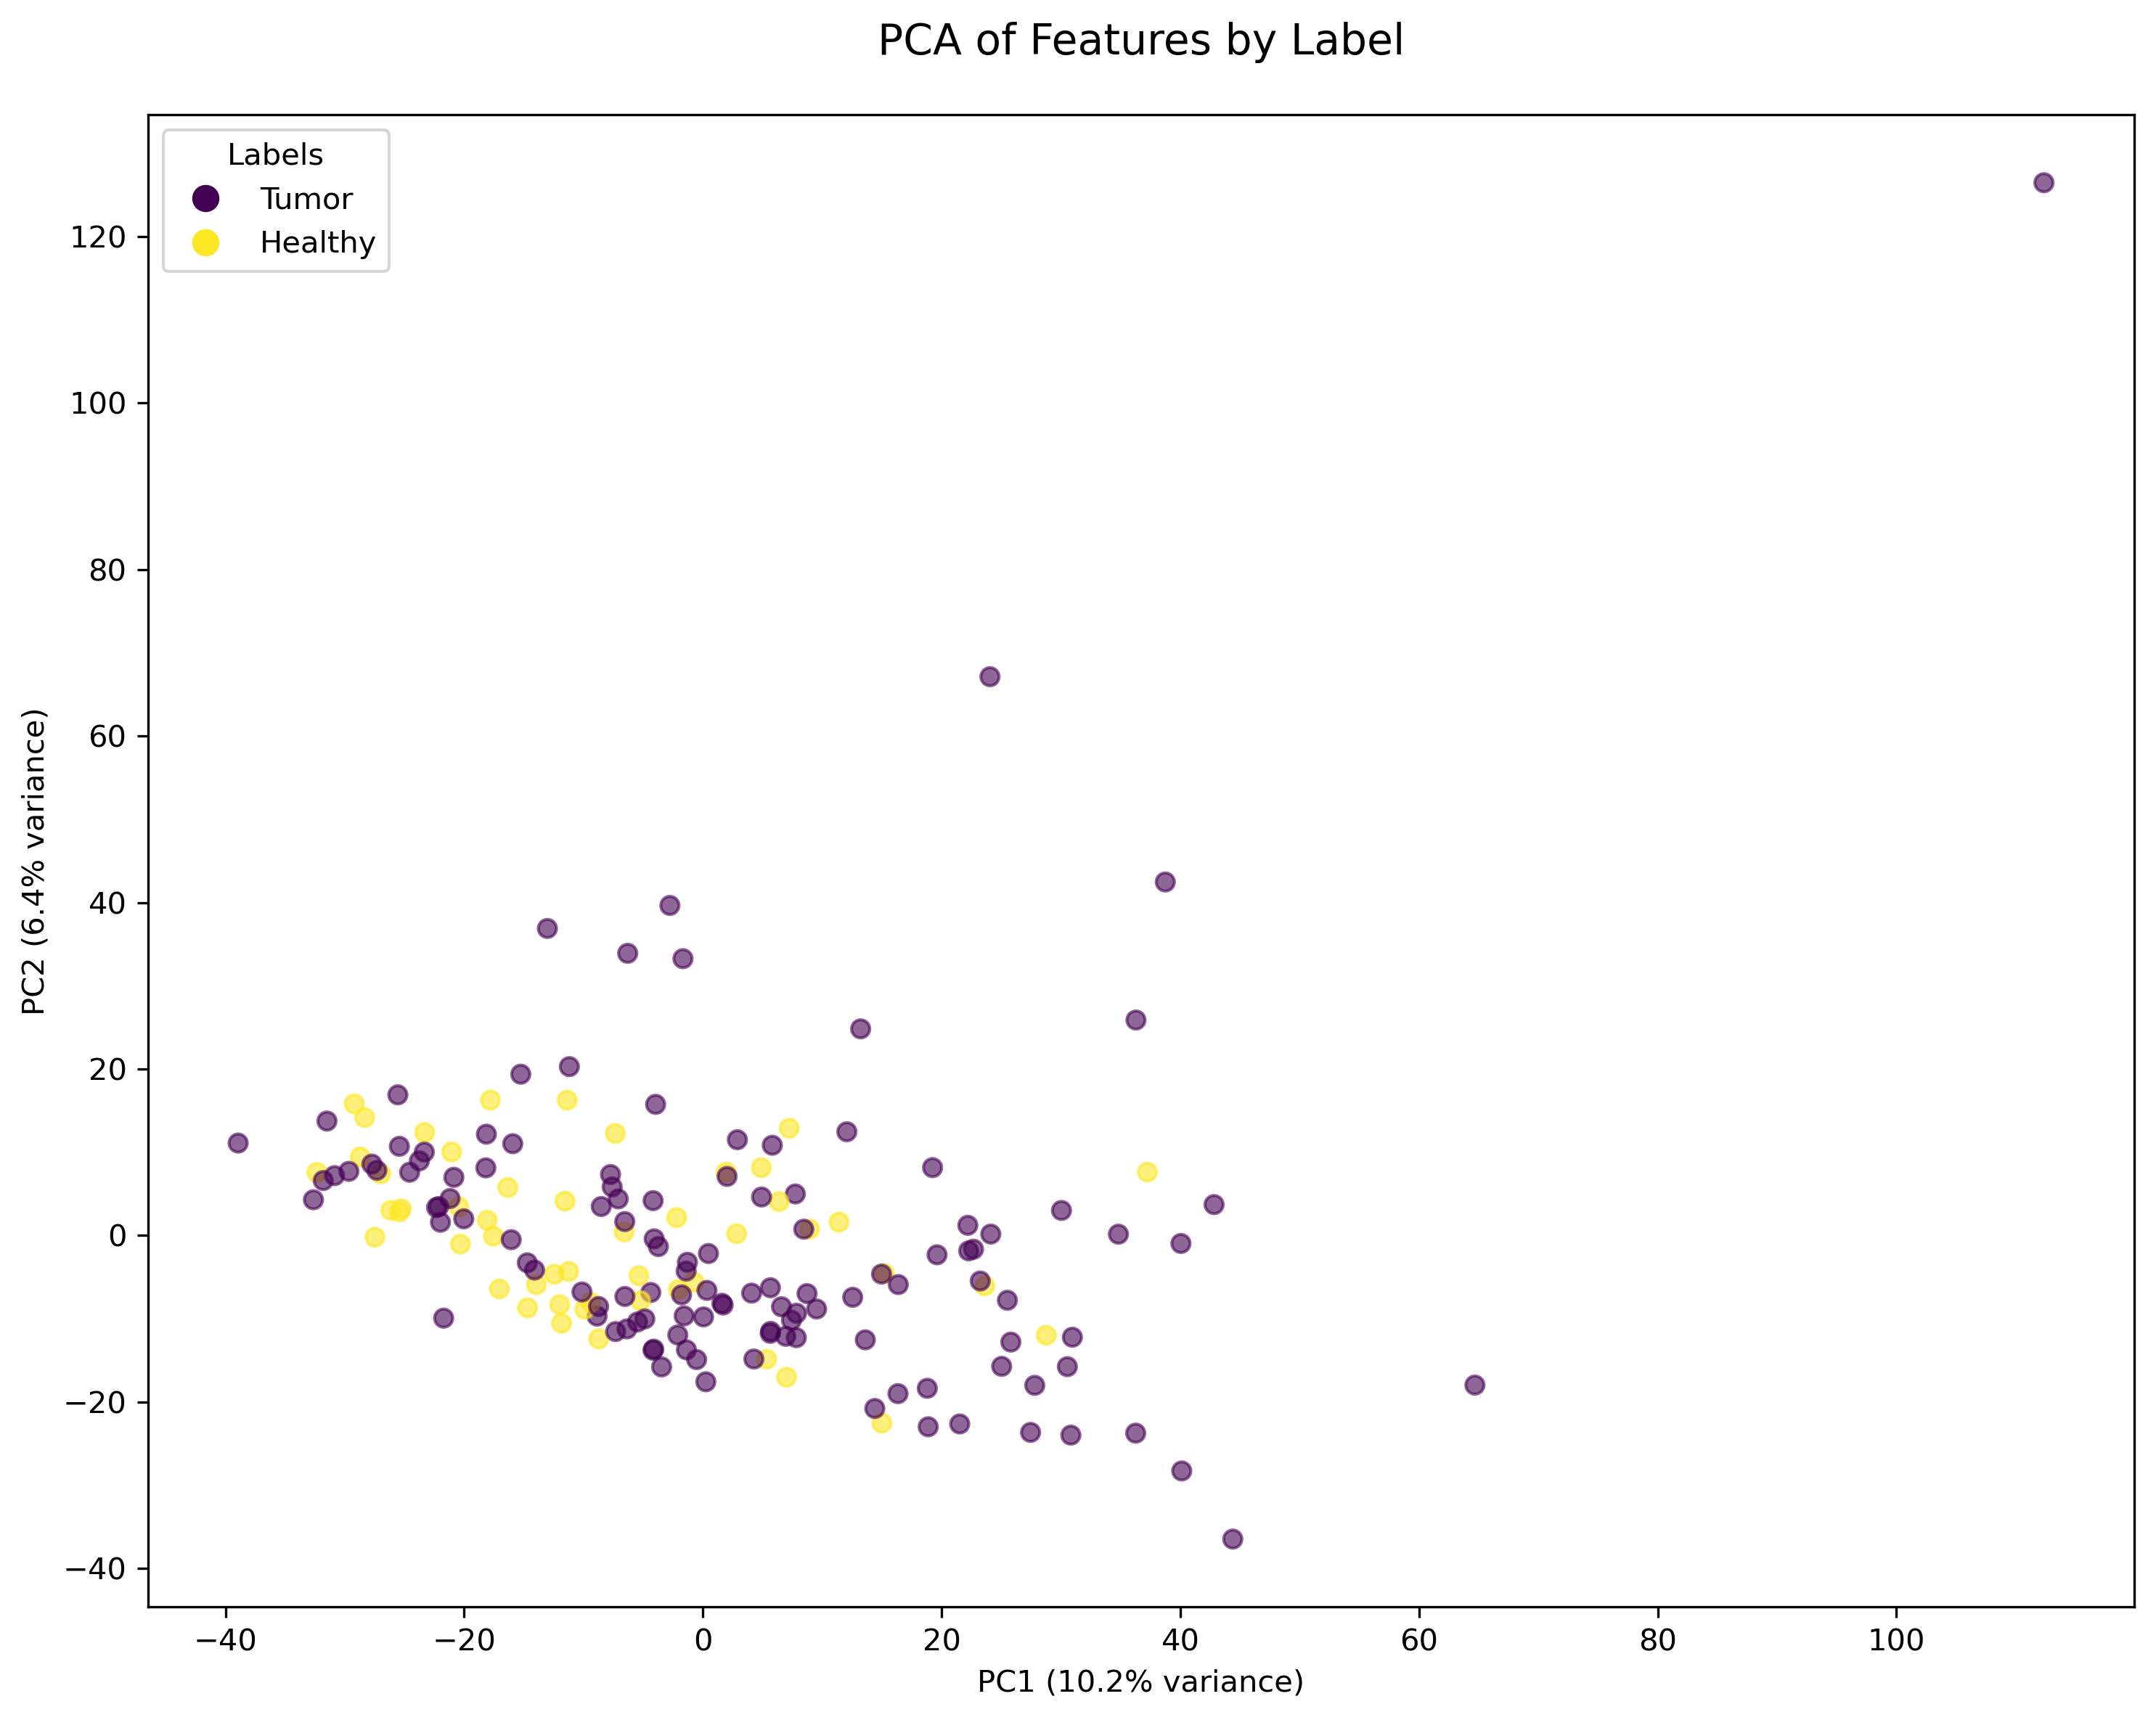


Top Features by Contribution to Principal Components:

Top 10 Most Important Features:
                   PC1    PC2  total_importance
hsa-miR-196a-5p  0.033 -0.036             0.069
hsa-miR-98-5p    0.035 -0.033             0.069
hsa-let-7c       0.037 -0.032             0.069
hsa-miR-200b-5p  0.033 -0.035             0.068
hsa-miR-182-5p   0.035 -0.034             0.068
hsa-miR-361-5p   0.035 -0.033             0.068
hsa-miR-10b-5p   0.032 -0.036             0.068
hsa-miR-204-3p   0.032 -0.036             0.068
hsa-miR-30c-2-3p 0.036 -0.032             0.068
hsa-mir-99b      0.035 -0.032             0.068


In [8]:
# 4. PCA Analysis
print("\nPerforming PCA Analysis...")
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
# Prepare data for PCA
# Impute missing values before scaling and PCA
imputer = SimpleImputer(strategy="mean")  # or "median", etc.
X_imputed = imputer.fit_transform(df[feature_cols])
X_scaled = StandardScaler().fit_transform(X_imputed)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create PCA plot
plt.figure(figsize=(10, 8))
plt.title('PCA of Features by Label', pad=20, fontsize=14)

# Create scatter plot with labels
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                     c=pd.factorize(df[label_col])[0],
                     cmap='viridis', alpha=0.6)

# Add legend
unique_labels = df[label_col].unique()
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor=scatter.cmap(scatter.norm(i)), 
                            label=label, markersize=10)
                  for i, label in enumerate(unique_labels)]
plt.legend(handles=legend_elements, title='Labels')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.tight_layout()
plt.show()

# Print feature importance summary
print("\nTop Features by Contribution to Principal Components:")
feature_importance = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=feature_cols
)
feature_importance['total_importance'] = np.abs(feature_importance).sum(axis=1)
print("\nTop 10 Most Important Features:")
print(feature_importance.sort_values('total_importance', ascending=False).head(10))

In [9]:
# Save processed data and models for next steps
import pickle
from pathlib import Path

# Create directory for saved objects if it doesn't exist
save_dir = Path('../data/processed')
save_dir.mkdir(parents=True, exist_ok=True)

# Dictionary to store all objects we want to save
objects_to_save = {
    'data': {
        'df': df,  # Original dataframe
        'feature_cols': feature_cols  # List of feature columns
    },
    'metadata': {
        'sample_id_col': sample_id_col,
        'label_col': label_col,
        'n_features': len(feature_cols),
        'n_samples': len(df),
        'label_distribution': df[label_col].value_counts().to_dict()
    }
}

output_file = save_dir / f'01_data_ingestion.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(objects_to_save, f)
print(f"Saved objects to {output_file}")

Saved objects to ../data/processed/01_data_ingestion.pkl
